In [1]:
import spotipy
import credentials
from spotipy.oauth2 import SpotifyClientCredentials

In [2]:
client_credentials_manager = SpotifyClientCredentials(client_id=credentials.client_id,client_secret=credentials.client_secret)

In [3]:
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

In [4]:
playlist = sp.user_playlists('11101312700')

In [5]:
playlist_id = []
for x in playlist['items']:
    print(x['id'])
    playlist_id.append(x['id'])

39ATQymddYN7NyYh9o1wJt
7FSgOU2Q9Gl5R87zzhqO1Z
6ZcX4ixA8PKFxJdR6DVfqV
4BNcSi9XkaG5cm72PKDn99
6es8TSbcJjrSKPTUZxMORa
1G4ORyc5h6Olgchb0Kl3h5
13udPXR4Won4caOrjvvroC
5LowI5UjWqm430rKUv0Iwa
6owYTn16XtOUViztPWlVvf
2rTJWSpwaOLcPdxeMbssyH
2EIvjOHXnp8sfEjqToBNnS
5HuLzhrjuwhGKTuDdnCk3M
023aBSqb2srsrLRQfogByu
6wrBeMzvOubFC22ozsPCl0
5XuZjIrovHayL7MHb3RRm1
0ryVBwLn6jVQTsnVvFDHGx
20uj6VoGusEQy2RLJpz9ft
4Ki6RtqYtNoHaGY5x72A37
0En3RXArq0yvOWzHj6nuXj
3KgmoRtq0tgqEqJFTVy4Lt
2eIDTCvvnk6Pp1J7sU3DUe
3dGYvHX3KYWEFfTjSAruQa
1Tc4sqnNsF6vM5ZnqMwXKO
0zpOu3lhHeJOaZYjh6s24c
0sevn1NwJEdbPGOGbkBNRf
1CA5Ey8DKN3PaQoknobGTj
39oosScTdRc8C5xSo2WSyx
5zlGyox1wlIEHvSv0tR9ma


In [6]:
def get_every_track_in_a_list_of_playlist(list_of_playlist):
    track_list = []
    for x in list_of_playlist:
        temp_list = sp.playlist_tracks('5zlGyox1wlIEHvSv0tR9ma')
        for y in temp_list['items']:
            track_list.append(y['track']['id'])
    return track_list

In [7]:
track_list = get_every_track_in_a_list_of_playlist(playlist_id)

In [8]:
len(track_list)

2156

In [20]:
columns = list(sp.audio_features(track_list[0])[0].keys())

In [30]:
sp.audio_features(track_list[0])[0]

{'danceability': 0.515,
 'energy': 0.74,
 'key': 10,
 'loudness': -5.507,
 'mode': 0,
 'speechiness': 0.363,
 'acousticness': 0.0493,
 'instrumentalness': 0,
 'liveness': 0.258,
 'valence': 0.765,
 'tempo': 75.922,
 'type': 'audio_features',
 'id': '2cgqvO5jXaLoAHLNCVT3Vz',
 'uri': 'spotify:track:2cgqvO5jXaLoAHLNCVT3Vz',
 'track_href': 'https://api.spotify.com/v1/tracks/2cgqvO5jXaLoAHLNCVT3Vz',
 'analysis_url': 'https://api.spotify.com/v1/audio-analysis/2cgqvO5jXaLoAHLNCVT3Vz',
 'duration_ms': 281133,
 'time_signature': 4}

In [31]:
audioft_list = []
for track in track_list:
    audioft_list.append(sp.audio_features(track)[0])
    

In [33]:
import pandas as pd

data = pd.DataFrame(audioft_list)

In [34]:
data

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature
0,0.515,0.740,10,-5.507,0,0.3630,0.04930,0.000000,0.2580,0.7650,75.922,audio_features,2cgqvO5jXaLoAHLNCVT3Vz,spotify:track:2cgqvO5jXaLoAHLNCVT3Vz,https://api.spotify.com/v1/tracks/2cgqvO5jXaLo...,https://api.spotify.com/v1/audio-analysis/2cgq...,281133,4
1,0.655,0.762,8,-3.427,0,0.3120,0.02190,0.000446,0.0930,0.3680,82.656,audio_features,2H72GU6mzrSfGj9R5SDGVP,spotify:track:2H72GU6mzrSfGj9R5SDGVP,https://api.spotify.com/v1/tracks/2H72GU6mzrSf...,https://api.spotify.com/v1/audio-analysis/2H72...,295667,4
2,0.621,0.672,4,-3.892,0,0.2760,0.21000,0.000000,0.1300,0.2280,83.808,audio_features,7cAHj6pGJUMGMJLBTs1JFe,spotify:track:7cAHj6pGJUMGMJLBTs1JFe,https://api.spotify.com/v1/tracks/7cAHj6pGJUMG...,https://api.spotify.com/v1/audio-analysis/7cAH...,251267,4
3,0.781,0.740,6,-5.065,0,0.2080,0.03750,0.000002,0.4490,0.5270,80.056,audio_features,67nAU2VBR1i9eBrVLuvajz,spotify:track:67nAU2VBR1i9eBrVLuvajz,https://api.spotify.com/v1/tracks/67nAU2VBR1i9...,https://api.spotify.com/v1/audio-analysis/67nA...,404427,4
4,0.701,0.728,2,-4.554,1,0.2550,0.00971,0.001150,0.3610,0.0591,171.388,audio_features,1JOgNMKbemRhrD9pjL7fKz,spotify:track:1JOgNMKbemRhrD9pjL7fKz,https://api.spotify.com/v1/tracks/1JOgNMKbemRh...,https://api.spotify.com/v1/audio-analysis/1JOg...,326467,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2151,0.924,0.740,8,-1.299,1,0.0774,0.08270,0.000000,0.1630,0.6210,133.974,audio_features,7iXF2W9vKmDoGAhlHdpyIa,spotify:track:7iXF2W9vKmDoGAhlHdpyIa,https://api.spotify.com/v1/tracks/7iXF2W9vKmDo...,https://api.spotify.com/v1/audio-analysis/7iXF...,222293,4
2152,0.750,0.825,11,-0.150,0,0.2690,0.25000,0.000000,0.1950,0.7640,92.028,audio_features,7GkrhcYfflOImusWPIFrPN,spotify:track:7GkrhcYfflOImusWPIFrPN,https://api.spotify.com/v1/tracks/7GkrhcYfflOI...,https://api.spotify.com/v1/audio-analysis/7Gkr...,244227,4
2153,0.891,0.607,10,-8.640,0,0.2380,0.28500,0.000000,0.1680,0.5090,94.028,audio_features,3myrzRJNm3fOLWliErE7GF,spotify:track:3myrzRJNm3fOLWliErE7GF,https://api.spotify.com/v1/tracks/3myrzRJNm3fO...,https://api.spotify.com/v1/audio-analysis/3myr...,148053,4
2154,0.516,0.497,9,-8.775,1,0.1840,0.49900,0.000017,0.0666,0.3270,181.542,audio_features,653FhwnB8YXSwqbuPn8eB4,spotify:track:653FhwnB8YXSwqbuPn8eB4,https://api.spotify.com/v1/tracks/653FhwnB8YXS...,https://api.spotify.com/v1/audio-analysis/653F...,243034,4


In [36]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import OneHotEncoder

In [37]:
features = ['danceability','energy','key','loudness','speechiness','acousticness'
           ,'instrumentalness','liveness','valence','tempo','duration_ms']

In [123]:
ohe = OneHotEncoder()

x = ohe.fit_transform(data[features])



In [124]:
x

<2156x711 sparse matrix of type '<class 'numpy.float64'>'
	with 23716 stored elements in Compressed Sparse Row format>

In [133]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=2)

x_reduced = svd.fit_transform(x)

x_reduced

array([[ 1.13729674, -0.33784237],
       [ 0.15353041, -0.55427933],
       [ 1.11026415, -0.13475528],
       ...,
       [ 1.11402809, -0.28352085],
       [ 0.10623741, -0.23177252],
       [ 1.24155322,  1.03309886]])

In [125]:
def calculate_wcss(data):
    wcss = []
    for n in range(2, 10):
        kmeans = KMeans(n_clusters=n)
        kmeans.fit(X=data)
        wcss.append(kmeans.inertia_)

    return wcss

In [126]:
wcss = calculate_wcss(x)

In [127]:
wcss

[21621.428571428478,
 21195.69565217398,
 20758.666666666577,
 20262.23010752667,
 19868.842131724512,
 19430.488888888758,
 18970.836257309937,
 18598.866666666552]

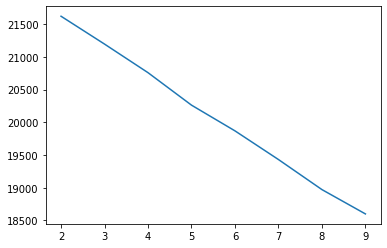

In [129]:
sns.lineplot(x=range(2,10), y=wcss)

In [130]:
kmeans = KMeans(n_clusters=4).fit(x)

In [131]:
labels = kmeans.predict(x)

In [93]:
centroids = kmeans.cluster_centers_
centroids

array([[ 1.24642947,  1.04496356],
       [ 1.11093932, -0.29775862],
       [ 0.08654564, -0.13600235],
       [ 0.26579114,  1.39456098]])

In [134]:
colors = ['red','blue','green','yellow']
assign = []
for row in labels:
    assign.append(colors[row])

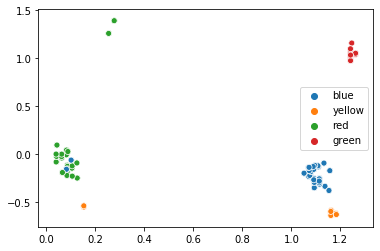

In [135]:
sns.scatterplot(x=x_reduced[:,0], y=x_reduced[:,1], hue=assign)

In [97]:
numbers = ['1','2','3','4']
assign_num = []
for row in labels:
    assign_num.append(numbers[row])

In [110]:
data

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature
0,0.515,0.740,10,-5.507,0,0.3630,0.04930,0.000000,0.2580,0.7650,75.922,audio_features,2cgqvO5jXaLoAHLNCVT3Vz,spotify:track:2cgqvO5jXaLoAHLNCVT3Vz,https://api.spotify.com/v1/tracks/2cgqvO5jXaLo...,https://api.spotify.com/v1/audio-analysis/2cgq...,281133,4
1,0.655,0.762,8,-3.427,0,0.3120,0.02190,0.000446,0.0930,0.3680,82.656,audio_features,2H72GU6mzrSfGj9R5SDGVP,spotify:track:2H72GU6mzrSfGj9R5SDGVP,https://api.spotify.com/v1/tracks/2H72GU6mzrSf...,https://api.spotify.com/v1/audio-analysis/2H72...,295667,4
2,0.621,0.672,4,-3.892,0,0.2760,0.21000,0.000000,0.1300,0.2280,83.808,audio_features,7cAHj6pGJUMGMJLBTs1JFe,spotify:track:7cAHj6pGJUMGMJLBTs1JFe,https://api.spotify.com/v1/tracks/7cAHj6pGJUMG...,https://api.spotify.com/v1/audio-analysis/7cAH...,251267,4
3,0.781,0.740,6,-5.065,0,0.2080,0.03750,0.000002,0.4490,0.5270,80.056,audio_features,67nAU2VBR1i9eBrVLuvajz,spotify:track:67nAU2VBR1i9eBrVLuvajz,https://api.spotify.com/v1/tracks/67nAU2VBR1i9...,https://api.spotify.com/v1/audio-analysis/67nA...,404427,4
4,0.701,0.728,2,-4.554,1,0.2550,0.00971,0.001150,0.3610,0.0591,171.388,audio_features,1JOgNMKbemRhrD9pjL7fKz,spotify:track:1JOgNMKbemRhrD9pjL7fKz,https://api.spotify.com/v1/tracks/1JOgNMKbemRh...,https://api.spotify.com/v1/audio-analysis/1JOg...,326467,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2151,0.924,0.740,8,-1.299,1,0.0774,0.08270,0.000000,0.1630,0.6210,133.974,audio_features,7iXF2W9vKmDoGAhlHdpyIa,spotify:track:7iXF2W9vKmDoGAhlHdpyIa,https://api.spotify.com/v1/tracks/7iXF2W9vKmDo...,https://api.spotify.com/v1/audio-analysis/7iXF...,222293,4
2152,0.750,0.825,11,-0.150,0,0.2690,0.25000,0.000000,0.1950,0.7640,92.028,audio_features,7GkrhcYfflOImusWPIFrPN,spotify:track:7GkrhcYfflOImusWPIFrPN,https://api.spotify.com/v1/tracks/7GkrhcYfflOI...,https://api.spotify.com/v1/audio-analysis/7Gkr...,244227,4
2153,0.891,0.607,10,-8.640,0,0.2380,0.28500,0.000000,0.1680,0.5090,94.028,audio_features,3myrzRJNm3fOLWliErE7GF,spotify:track:3myrzRJNm3fOLWliErE7GF,https://api.spotify.com/v1/tracks/3myrzRJNm3fO...,https://api.spotify.com/v1/audio-analysis/3myr...,148053,4
2154,0.516,0.497,9,-8.775,1,0.1840,0.49900,0.000017,0.0666,0.3270,181.542,audio_features,653FhwnB8YXSwqbuPn8eB4,spotify:track:653FhwnB8YXSwqbuPn8eB4,https://api.spotify.com/v1/tracks/653FhwnB8YXS...,https://api.spotify.com/v1/audio-analysis/653F...,243034,4
